In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit

import emcee
import corner

from altaipony.fakeflares import flare_model
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve

from astropy import units as u
from astropy.modeling import models
from astropy.constants import sigma_sb

def flare_factor(teff, radius, wav, resp,  tflare=10000):
    """Calculate the flare energy factor in ergs, following Shibayama et al. (2013)

    Parameters
    ----------
    teff : float
        Stellar effective temperature in Kelvin.
    radius : float
        Stellar radius in solar radii.
    wav : array
        Array of wavelengths in nanometers.
    resp : array
        Array of bandpass responses.
     tflare : float
        Flare temperature in Kelvin.
    
    Returns
    -------
    factor : float
        Flare energy factor in ergs/s.
    """

    # blackbody
    bb = models.BlackBody(temperature=teff * u.K)

    # blackbody flux in TESS band
    bbwavs = bb(wav * u.nm)  * resp

    fluxs = np.trapz(bbwavs.value, wav)

    # blackbody
    bb = models.BlackBody(temperature=tflare * u.K)

    # blackbody flux in TESS band
    bbwavf = bb(wav * u.nm)  * resp

    fluxf = np.trapz(bbwavf.value, wav)

    ratio = fluxs / fluxf

    factor = ratio * np.pi * (radius * u.R_sun) ** 2 * sigma_sb * (tflare * u.K)**4

    return factor.to("erg/s")



In [320]:
# GET THE IMAGE DATA -----------------------------------------------------------
file = "20240622064513"
IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/hip67522_CHEOPS-products-{file}_im.fits'
hdulist = fits.open(IMG)
print(f"Imagette file found for {file}:\n {IMG}\n")


# get the image data
image_data = hdulist[1].data

t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

# make sure the data is in fact 10s cadence
assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Ti/me series is not 10s cadence"

# big endian to little endian
t = t.byteswap().newbyteorder()
f = f.byteswap().newbyteorder()
ferr = ferr.byteswap().newbyteorder()
roll = roll.byteswap().newbyteorder()


Imagette file found for 20240622064513:
 ../data/hip67522/CHEOPS-products-20240622064513/Outdata/00000/hip67522_CHEOPS-products-20240622064513_im.fits



/tmp/ipykernel_55726/2771817306.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240617054558/Outdata/00000/hip67522_CHEOPS-products-20240617054558_im.fits'>
  hdulist = fits.open(IMG)


In [323]:

# initial masking

egress = 2460483.18998
mask = (f < 2.9e6) & (f > 2.4e6) &  (t>egress+0.02)#(t > egress + 0.03)~((2460413.39403 - 0.02<t) & 2460413.59495



print(f"Initial mask: {mask.sum()} data points")


Initial mask: 1851 data points


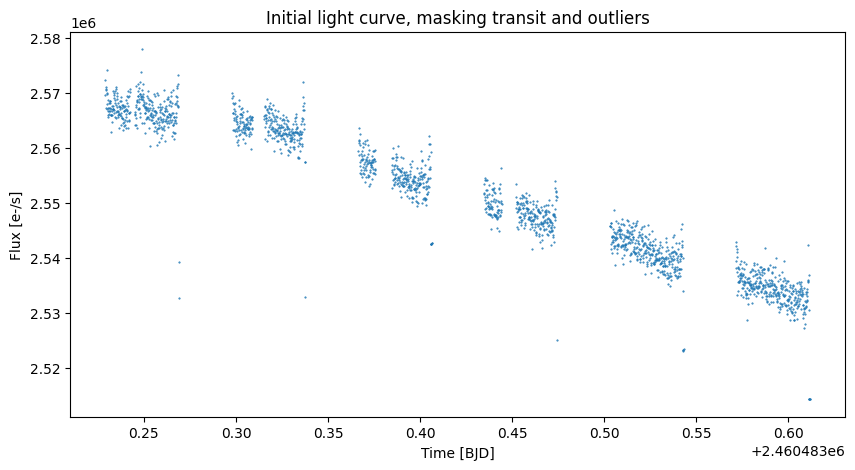

In [324]:
%matplotlib inline
t = t[mask]
f = f[mask]
roll = roll[mask]
ferr = ferr[mask]

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Initial light curve, masking transit and outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_initial_lc.png")

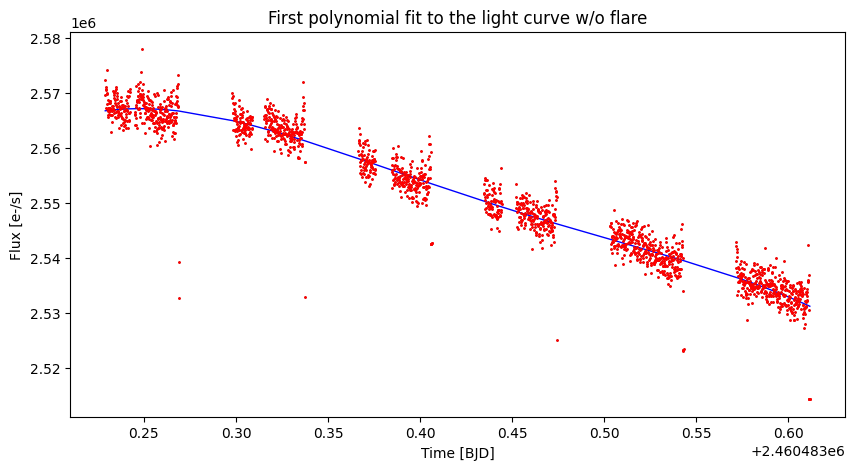

In [325]:

# 5th degree polynomial with a time offset
offset2 = t[-1]
def func(x, a, b, c, d, e, f, offset):
    return (f * (x - offset2 + offset)**5 + 
            e * (x - offset2 + offset)**4 + 
            a * (x - offset2 + offset)**3 + 
            b * (x - offset2 + offset)**2 + 
            c * (x - offset2 + offset) + d
)

popt, pcov = curve_fit(func, t, f, p0=[-1.45888787e+04, -1.41685433e+08, -1.03596058e+09,  1.00000000e+00,
        1.19292031e-02, -2.42900480e-09,  8.42088604e-01])

fitted = func(t, *popt)



plt.figure(figsize=(10, 5))

plt.plot(t, fitted, color="blue", lw=1)
plt.plot(t, f, ".", markersize=1, color="black")
plt.plot(t, f, ".", markersize=2, color="red")

plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("First polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_init.png")

Outliers: 32


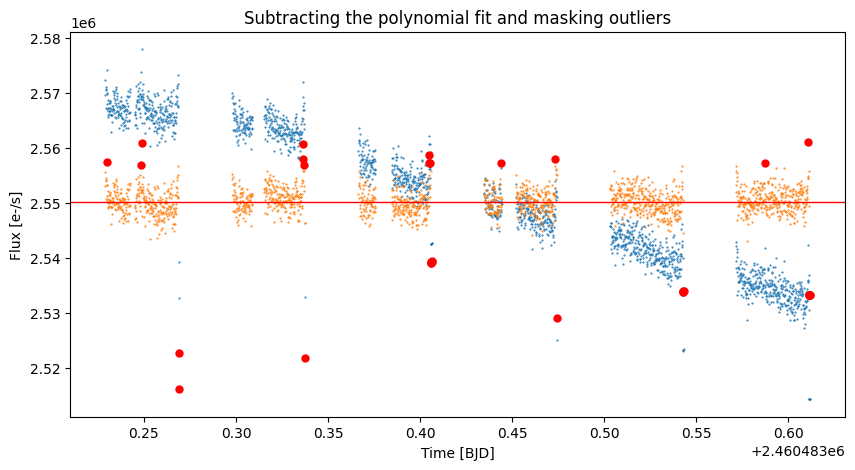

In [326]:
# subtract fitted from f
med = np.median(f)
f_sub = f - fitted + med

mask_outliers = (f_sub > 1.0026 * med) | (f_sub < 0.996 * med)
print(f"Outliers: {mask_outliers.sum()}")

plt.figure(figsize=(10, 5))
plt.plot(t, f, ".", markersize=1)
plt.plot(t, f_sub, ".", markersize=1)
plt.axhline(med, color="red", lw=1)

# plot masked outliers
plt.plot(t[mask_outliers], f_sub[mask_outliers], ".", markersize=10, color="red")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Subtracting the polynomial fit and masking outliers")
plt.savefig(f"../plots/{file}/flares/hip67522_subtract_polyfit_init.png")


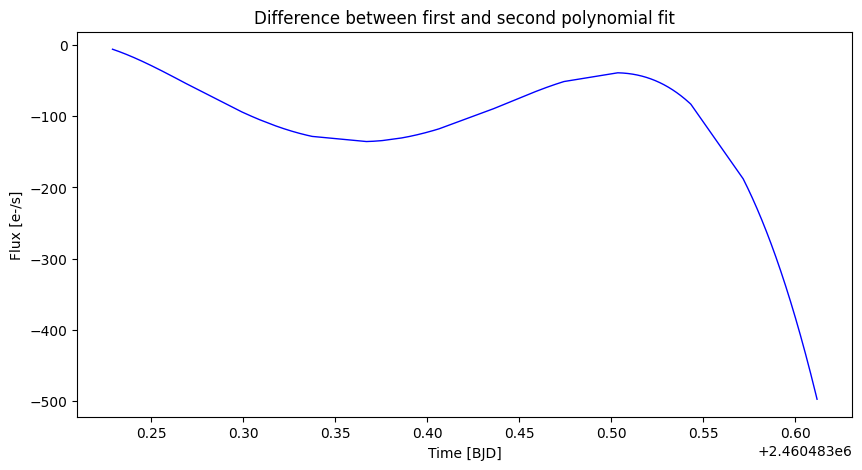

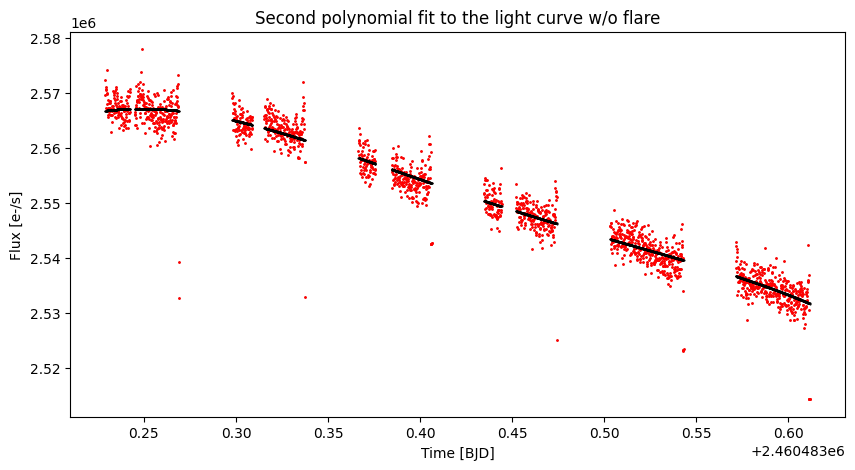

In [327]:
tnew = t[~mask_outliers]
fnew = f[~mask_outliers]
popt, pcov = curve_fit(func, tnew, fnew, p0=popt)

newfitted = func(t, *popt)


newmed = np.median(f[~mask_outliers])
newf_sub = f - fitted + med


plt.figure(figsize=(10, 5))
plt.plot(t, fitted-newfitted, color="blue", lw=1)
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Difference between first and second polynomial fit")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_diff.png")

plt.figure(figsize=(10, 5))

plt.plot(t, f, ".", markersize=1, color="grey")
plt.plot(t, f, ".", markersize=2, color="red")
plt.plot(t, newfitted, ".", markersize=1, color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.title("Second polynomial fit to the light curve w/o flare")
plt.savefig(f"../plots/{file}/flares/hip67522_polyfit_final.png")


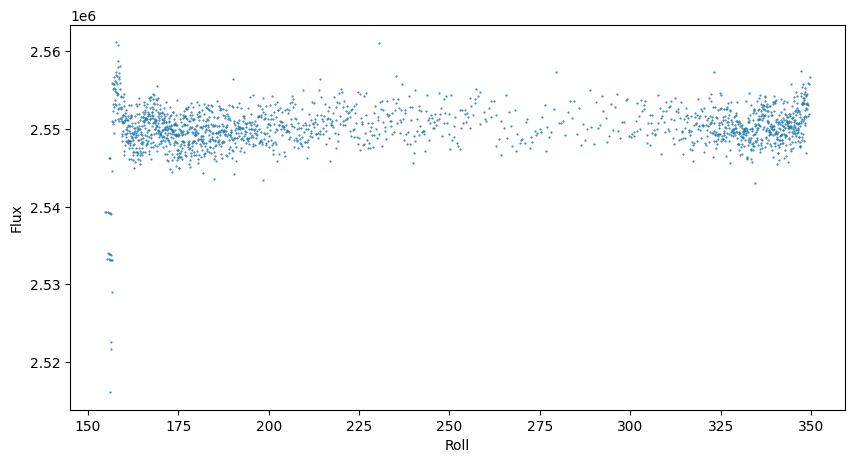

In [328]:
# plot f_sub against roll
plt.figure(figsize=(10, 5))
plt.plot(roll, newf_sub, ".", markersize=1)
plt.xlabel("Roll")
plt.ylabel("Flux")
plt.savefig(f"../plots/{file}/flares/hip67522_roll_flux.png")

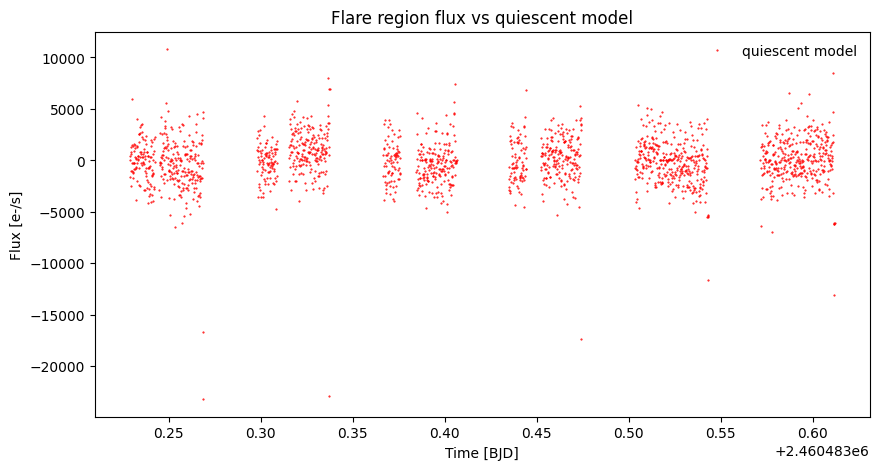

In [329]:
# approximate the flux at the roll values in the flare region with 
# the flux at the closest roll value in the non-flare region

f_sub_no_flare = newf_sub
roll_no_flare = roll

f_sub_no_flare_approx = np.zeros_like(f_sub_no_flare)
for i, r in enumerate(roll_no_flare):
    
    idx = [np.argmin(np.abs(roll_no_flare - r-delt)) for delt in np.linspace(-2, 2, 100)]
    # print(idx)
    f_sub_no_flare_approx[i] = np.median(f_sub_no_flare[idx])


plt.figure(figsize=(10, 5))
plt.plot(t, f_sub_no_flare - f_sub_no_flare_approx, ".", markersize=1, color="red", label="quiescent model")
# plt.plot(t[flare_mask], f_sub_flare, ".", markersize=1, color="blue", label="flare region")
# plt.plot(t[~flare_mask], f_sub_no_flare, ".", markersize=1, color="black", label="non-flare region")
# plt.axhline(newmed, color="black", lw=1)



plt.xlabel("Time [BJD]")
plt.ylabel("Flux [e-/s]")
plt.legend(loc=0, frameon=False)
plt.title("Flare region flux vs quiescent model")
plt.savefig(f"../plots/{file}/flares/hip67522_flare_vs_quiescent_model.png")


In [334]:
ff = f_sub_no_flare - f_sub_no_flare_approx + newmed
flc = FlareLightCurve(time = t, flux = ff, flux_err=np.std(ff))
flc.detrended_flux = ff 
flc.detrended_flux_err = np.std(ff)

flares = flc.find_flares(N1=1,N2=1,N3=2).flares
flares

Found 1 candidate(s) in the (0,1851) gap.
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/altaipony/altai.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lc.flares = pd.concat([lc.flares, new], ignore_index=True)


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,610,612,NaN,NaN,2.460483e+06,2.460483e+06,6.855603,1.599028,0.002725,0.029121,1851.0


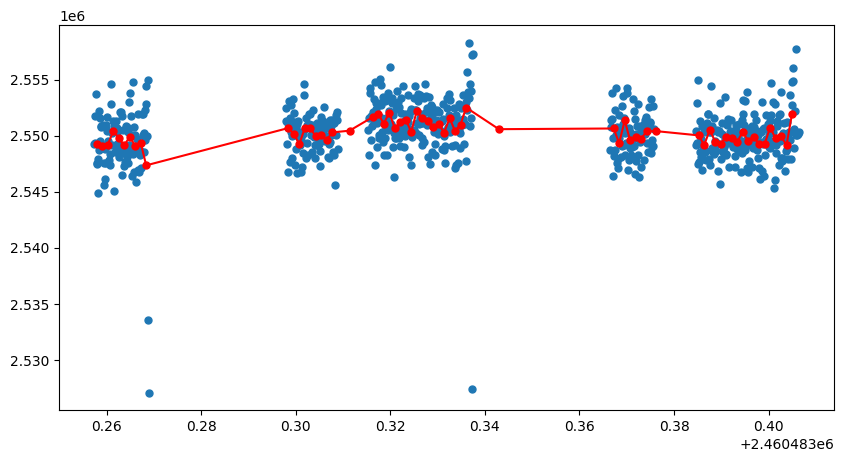

In [335]:
# plot each flare from the flares list
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
    

    flare_m = (t > row.tstart - 0.08) & (t < row.tstop + 0.066)

    tflare = t[flare_m]
    fflare = ff[flare_m]

    plt.plot(tflare, fflare, ".", markersize=10)

    # now bin the data
    binsize = 10

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)

    
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red")